In [1]:
rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine
rho_o=0.78;   k_o=0.94              # fluid properties, oil
rho_g=0.25;   k_g=0.06              # fluid properties, gas

# Some constants used in the transformation

phi = 0.2
K_dry = 12
K0 = 36
T = 80
P_p = 300

# using Batzle-Wang
# gas gravity = 1
# water salinity = 50000
K_gas = 0.133; rho_gas = 0.336
K_water = 3.013; rho_water = 1.055


# 5.1 Case 1: Seismic reservoir mapping from 3D AVO in a North Sea turbidite system

## 5.1.1 Introduction

The Glitne field is a turbidite system

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
from packages.functions import * # vrh, softsand, stiffsand, hertzmindlin, vels, rpt
# are the vrh inputs vectors?

In [4]:
well1 = pd.read_csv("./data/well_1.txt", header=None, skiprows=1, sep="  ", usecols=[0,4,8,11])
well1.rename(columns={0:"DEPTH", 4:"VP", 8:"DEN", 11:"GR"}, inplace=True)

well2 = pd.read_csv("./data/well_2.txt", header=None, skiprows=1, sep="  ", usecols=[0,3,6,9,11,14])
well2.rename(columns={0:"DEPTH", 3:"VP", 6:"VS", 9:"DEN", 11:"GR", 14:"NPHI" }, inplace=True)

well3 = pd.read_csv("./data/well_3.txt", header=None, skiprows=1, sep=" ", usecols=[5,13,17,24])
well3.rename(columns={5:"DEPTH", 13:"VP", 17:"DEN", 24:"GR"}, inplace=True)

#well4 = pd.read_csv("./data/well_4.txt", header=None, skiprows=1, sep=" ", usecols=[4,12,20,27])
#well4.rename(columns={4:"DEPTH", 12:"VP", 20:"DEN", 27:"GR"}, inplace=True)

#well5 = pd.read_csv("./data/well_5.txt", header=None, skiprows=1, sep=" ", usecols=[3,6,9,12,15])
#well5.rename(columns={3:"DEPTH", 6:"t_p", 9:"t_s", 12:"GR", 15:"DEN"}, inplace=True)

In [5]:
well2["PHIE"] = (2.65- well2.DEN)/(2.65 - 1.05)
well2["VSH"] = (well2.GR - 40) / (140-40)
well2["IP"] = well2.VP*1000 * well2.DEN
well2["IS"] = well2.VS*1000 * well2.DEN
well2["VPVS"] = well2.VP / well2.VS
well2['K'] = well2.DEN*(well2.VP**2 - 4/3.*(well2.VS)**2)

In [6]:
# 
shale = well2.VSH.values  # 
#shale = df.VWCL.values

sand = 1 - shale - well2.PHIE.values
shaleN = shale / (shale+sand)  # normalized shale and sand volumes
sandN  = sand / (shale+sand)

# mineral mixture bulk and shear moduli, k0 and mu0
k_u, k_l, mu_u, mu_l, k0, mu0 = vrh([shaleN, sandN], [k_sh, k_qz], [mu_sh, mu_qz])

well2['K0'] = k0

In [7]:
well2.head()

,DEPTH,VP,VS,DEN,GR,NPHI,PHIE,VSH,IP,IS,VPVS,K,K0
0,2013.2528,2.2947,0.8769,1.9972,91.8785,0.4908,0.408000,0.518785,4582.97484,1751.34468,2.616832,8.468880,16.955708
1,2013.4052,2.2967,0.9430,2.0455,86.8004,0.4833,0.377812,0.468004,4697.89985,1928.90650,2.435525,8.364388,19.021958
2,2013.5576,2.2904,0.9125,2.1122,86.0021,0.4474,0.336125,0.460021,4837.78288,1927.38250,2.510027,8.735476,20.052948
3,2013.7100,2.2775,0.8916,2.1960,87.3570,0.4140,0.283750,0.473570,5001.39000,1957.95360,2.554397,9.063050,20.619171
4,2013.8624,2.2620,0.8905,2.2020,90.4024,0.4293,0.280000,0.504024,4980.92400,1960.88100,2.540146,8.938631,19.927703


### Figure 5.1
Well 1, Well 2, Well 3 displaying Depth vs Vp

### Figure 5.3
(Well 2) Vp vs GR, Density vs GR, Acoustic Impedance vs GR, Vp/Vs vs Gr

## 5.1.2 Rock physics and facies analysis of well-log data

In [8]:
## I think the facies and related depths are for a different well ????????????????????????????????????????

## well2 should be
# Facies I: Gravels => not used
# Facies II: Thick bedded sandstones; IIa, IIb, IIc, IId
# Facies III: Interbedded sandstone-shale
# Facies IV: Silty shales and silt-laminated shale
# Facies V: Pure shales
# Facies VI: Chaotic deposits => not used

facies = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]
colors = ["black", "brown", "green", "purple", "orange", "magenta"]

conditions = [
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
]
well2["FACIES"] = np.select(conditions, facies)

reservoir = [0, 0, 1, 1, 0, 1]
conditions = [
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
]

well2["RESERVOIR"] = np.select(conditions, reservoir)

In [10]:
# create frm logs
#logs = df[df.RESERVOIR == 1]
sand = (well2.RESERVOIR == 1)
shale = (well2.RESERVOIR == 0)

vpg, vsg, rhog, kg = frm(well2.VP, well2.VS, well2.DEN, rho_b, k_b, rho_o, k_o, well2.K0, well2.PHIE)

well2['VP_FRMO'] = well2.VP
well2['VS_FRMO'] = well2.VS
well2['RHO_FRMO'] = well2.DEN

In [11]:
well2['VP_FRMO'][sand] = vpg[sand]
well2['VS_FRMO'][sand] = vsg[sand]
well2['RHO_FRMO'][sand] = rhog[sand]

well2['IP_FRMO'] = well2.VP_FRMO*well2.RHO_FRMO*1000
well2['IS_FRMO'] = well2.VS_FRMO*well2.RHO_FRMO*1000
well2['VPVS_FRMO'] = well2.VP_FRMO/well2.VS_FRMO

In [12]:
well2.head()

,DEPTH,VP,VS,DEN,GR,NPHI,PHIE,VSH,IP,IS,VPVS,K,K0,FACIES,RESERVOIR,VP_FRMO,VS_FRMO,RHO_FRMO,IP_FRMO,IS_FRMO,VPVS_FRMO
0,2013.2528,2.2947,0.8769,1.9972,91.8785,0.4908,0.408000,0.518785,4582.97484,1751.34468,2.616832,8.468880,16.955708,0,0,2.2947,0.8769,1.9972,4582.97484,1751.34468,2.616832
1,2013.4052,2.2967,0.9430,2.0455,86.8004,0.4833,0.377812,0.468004,4697.89985,1928.90650,2.435525,8.364388,19.021958,0,0,2.2967,0.9430,2.0455,4697.89985,1928.90650,2.435525
2,2013.5576,2.2904,0.9125,2.1122,86.0021,0.4474,0.336125,0.460021,4837.78288,1927.38250,2.510027,8.735476,20.052948,0,0,2.2904,0.9125,2.1122,4837.78288,1927.38250,2.510027
3,2013.7100,2.2775,0.8916,2.1960,87.3570,0.4140,0.283750,0.473570,5001.39000,1957.95360,2.554397,9.063050,20.619171,0,0,2.2775,0.8916,2.1960,5001.39000,1957.95360,2.554397
4,2013.8624,2.2620,0.8905,2.2020,90.4024,0.4293,0.280000,0.504024,4980.92400,1960.88100,2.540146,8.938631,19.927703,0,0,2.2620,0.8905,2.2020,4980.92400,1960.88100,2.540146


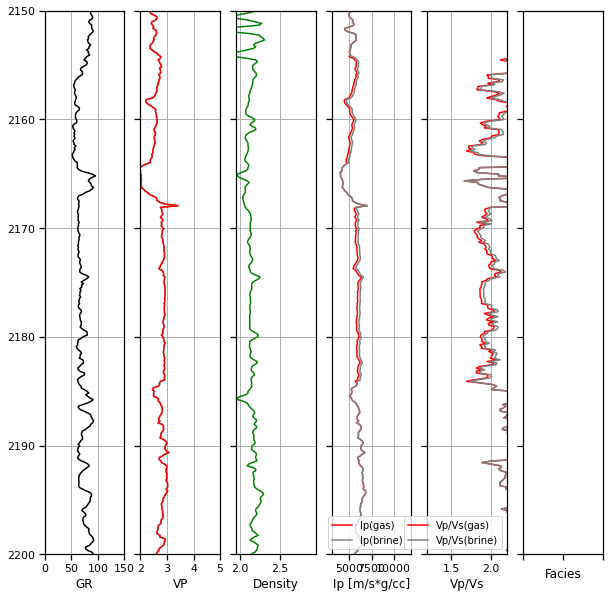

In [13]:
df = well2.copy()
import matplotlib.colors as colors
#      0=shale   1=sand  2=interbedded   3=limestone 4=Salt
ccc = ['#1B4F72','#F4D03F','#DC7633','#AED6F1','red']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')


ztop=2150; zbot=2200
ll=df[(df.DEPTH>=ztop) & (df.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['FACIES'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 10))
ax[0].plot(ll.GR, ll.DEPTH, '-k', label='GR')
ax[1].plot(ll.VP, ll.DEPTH, 'gray', label='VP')
ax[1].plot(ll.VP_FRMO, ll.DEPTH, 'r')
ax[2].plot(ll.DEN, ll.DEPTH, '-g', label='Density')

ax[3].plot(ll.IP_FRMO, ll.DEPTH, '-r', label='Ip(gas)')
ax[3].plot(ll.IP, ll.DEPTH, '-', color='0.5', label='Ip(brine)')

ax[4].plot(ll.VPVS_FRMO, ll.DEPTH, '-r', label='Vp/Vs(gas)')
ax[4].plot(ll.VPVS, ll.DEPTH, '-', color='0.5', label='Vp/Vs(brine)')
# # im=ax[5].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)#4)

# # cbar=plt.colorbar(im, ax=ax[5], aspect=20)
# cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
# cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1))
# # cbar.set_label((6*' ').join(['shale', 'sand', 'interbed', 'limestone', 'salt']))#, 'shale']))
# # cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

for i in range(len(ax)-1):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=4)
#ax[0].legend(fontsize='small', loc='lower right')

ax[0].set_xlabel("GR"),            ax[0].set_xlim(0, 150),     
ax[1].set_xlabel("VP"),            ax[1].set_xlim(2, 5), ax[1].set_yticklabels([])
ax[2].set_xlabel("Density"),       ax[2].set_xlim(1.95, 2.95), ax[2].set_yticklabels([])
ax[3].set_xlabel("Ip [m/s*g/cc]"), ax[3].set_xlim(3000,12000), ax[3].set_yticklabels([]), ax[3].legend(fontsize='small', loc='lower right')
ax[4].set_xlabel("Vp/Vs"),         ax[4].set_xlim(1.2,2.2),    ax[4].set_yticklabels([]), ax[4].legend(fontsize='small', loc='lower right')
ax[5].set_xlabel('Facies'),        ax[5].set_yticklabels([]),  ax[5].set_xticklabels([]);

# for i in range (5):
#     for top in tops.values() :
#         f.axes[i].axhline( y = float(top), color = 'b', lw = 2, 
#                             ls = ':',  
#                             alpha = 0.5, xmin = 0.05, xmax = 0.95 )
# for top, depth in tops.items():
#     if (ztop < depth < zbot):
#         ax[0].text( x = max(ax[0].xaxis.get_data_interval())*1.0,
#                   y = float(depth), s = top,
#                              alpha=0.75, color='k',
#                              fontsize = '10',
#                              horizontalalignment = 'left',
#                              verticalalignment = 'center',
#                              bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
#                              weight = 'light')


    
#plt.savefig("./images/logs_basic_co2_modeling.png")

### Figure 5.5
(Well 2) Depth vs Water saturation (Sw, Sxo)

### Figure 5.6
(Well 2) Depth vs Total porosity (He porosity, water porosity, oil porosity)

### Figure 5.7
Seismic lithofacies classification results in the three wells (Well 1, Well 2, Well 3).

## 5.1.3 Creating nonparametric facies and pore-fluid pdfs

The log data from the type-well (Well 2) are used as training data for a multivariate statistical classification of seismic lithofacies in other wells (Well 1, Well 3).  Only gamma-ray and P-wave velocity logs were used.

Based on the facies classification, we first extract cdfs of seismic properties for each of the lithofacies, and for oil-saturated sand facies. Use FRM to obtain oil-saturated cdfs.

As for the training data, we observe a much better discrimination in Vp/Vs ratio than in acoustic impedance in terms of lithofacies and pore fluids. Hence, AVO must be used to predict lithofacies from seismic data.

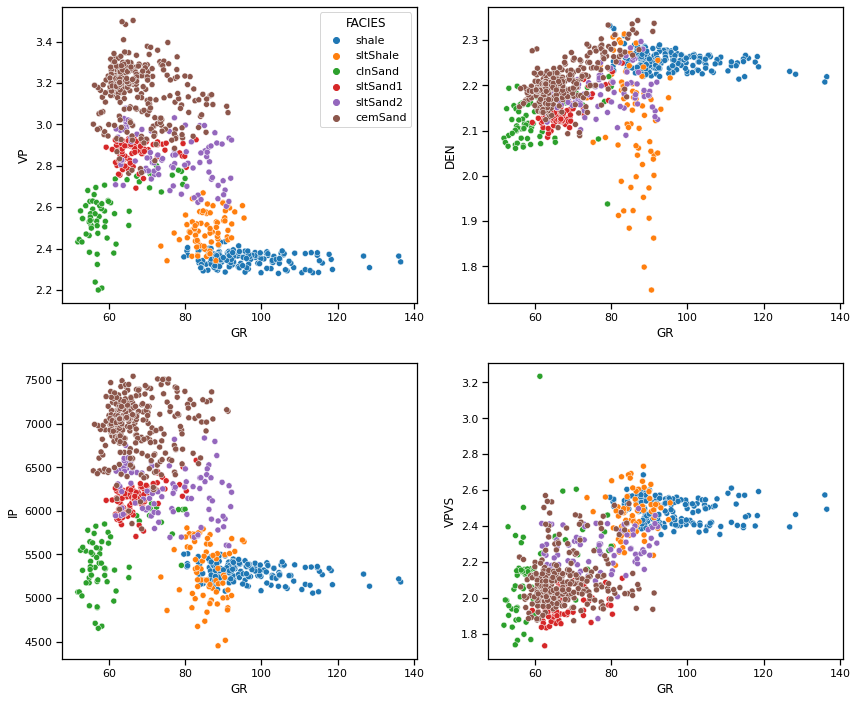

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,12))
sns.scatterplot(ax=ax1, data=well2[well2.FACIES!='0'], x="GR", y="VP", hue='FACIES')
sns.scatterplot(ax=ax2, data=well2[well2.FACIES!='0'], x="GR", y="DEN", hue='FACIES', legend=False)
sns.scatterplot(ax=ax3, data=well2[well2.FACIES!='0'], x="GR", y="IP", hue='FACIES', legend=False)
sns.scatterplot(ax=ax4, data=well2[well2.FACIES!='0'], x="GR", y="VPVS", hue='FACIES', legend=False);

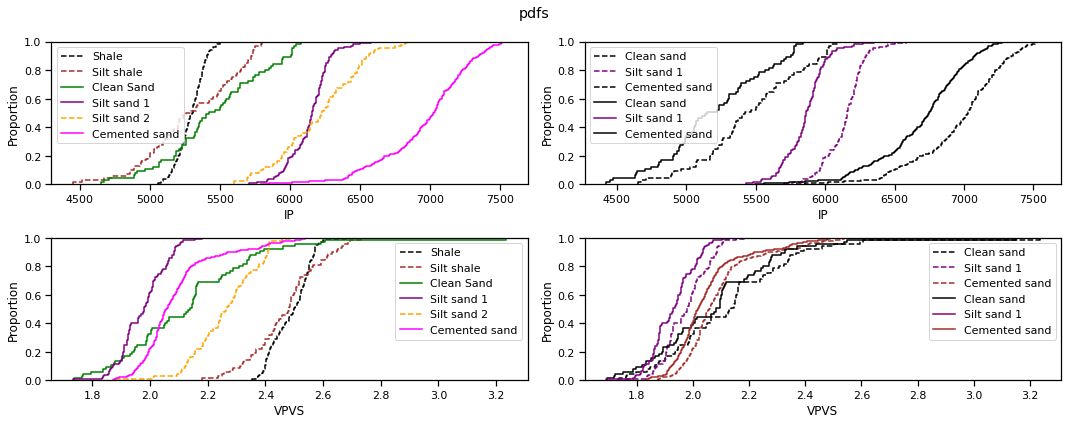

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,6))
fig.suptitle('pdfs')
sns.ecdfplot(ax=ax1, x=well2[well2.FACIES==facies[0]]['IP'], color="black", ls='--', label="Shale")
sns.ecdfplot(ax=ax1, x=well2[well2.FACIES==facies[1]]['IP'], color="brown", ls='--', label="Silt shale")
sns.ecdfplot(ax=ax1, x=well2[well2.FACIES==facies[2]]['IP'], color="green", label="Clean Sand")
sns.ecdfplot(ax=ax1, x=well2[well2.FACIES==facies[3]]['IP'], color="purple", label="Silt sand 1")
sns.ecdfplot(ax=ax1, x=well2[well2.FACIES==facies[4]]['IP'], color="orange", ls='--', label="Silt sand 2")
sns.ecdfplot(ax=ax1, x=well2[well2.FACIES==facies[5]]['IP'], color="magenta", label="Cemented sand")

sns.ecdfplot(ax=ax3, x=well2[well2.FACIES==facies[0]]['VPVS'], color="black",ls='--', label="Shale")
sns.ecdfplot(ax=ax3, x=well2[well2.FACIES==facies[1]]['VPVS'], color="brown",ls='--', label="Silt shale")
sns.ecdfplot(ax=ax3, x=well2[well2.FACIES==facies[2]]['VPVS'], color="green", label="Clean Sand")
sns.ecdfplot(ax=ax3, x=well2[well2.FACIES==facies[3]]['VPVS'], color="purple", label="Silt sand 1")
sns.ecdfplot(ax=ax3, x=well2[well2.FACIES==facies[4]]['VPVS'], color="orange",ls='--', label="Silt sand 2")
sns.ecdfplot(ax=ax3, x=well2[well2.FACIES==facies[5]]['VPVS'], color="magenta", label="Cemented sand")

sns.ecdfplot(ax=ax2, x=well2[well2.FACIES==facies[2]]['IP'], color="black", ls='--', label="Clean sand")
sns.ecdfplot(ax=ax2, x=well2[well2.FACIES==facies[3]]['IP'], color="purple", ls='--', label="Silt sand 1")
sns.ecdfplot(ax=ax2, x=well2[well2.FACIES==facies[5]]['IP'], color="black", ls='--', label="Cemented sand")
sns.ecdfplot(ax=ax2, x=well2[well2.FACIES==facies[2]]['IP_FRMO'], color="black", label="Clean sand")
sns.ecdfplot(ax=ax2, x=well2[well2.FACIES==facies[3]]['IP_FRMO'], color="purple", label="Silt sand 1")
sns.ecdfplot(ax=ax2, x=well2[well2.FACIES==facies[5]]['IP_FRMO'], color="black", label="Cemented sand")

sns.ecdfplot(ax=ax4, x=well2[well2.FACIES==facies[2]]['VPVS'], color="black", ls='--', label="Clean sand")
sns.ecdfplot(ax=ax4, x=well2[well2.FACIES==facies[3]]['VPVS'], color="purple", ls='--', label="Silt sand 1")
sns.ecdfplot(ax=ax4, x=well2[well2.FACIES==facies[5]]['VPVS'], color="brown", ls='--', label="Cemented sand")
sns.ecdfplot(ax=ax4, x=well2[well2.FACIES==facies[2]]['VPVS_FRMO'], color="black", label="Clean sand")
sns.ecdfplot(ax=ax4, x=well2[well2.FACIES==facies[3]]['VPVS_FRMO'], color="purple", label="Silt sand 1")
sns.ecdfplot(ax=ax4, x=well2[well2.FACIES==facies[5]]['VPVS_FRMO'], color="brown", label="Cemented sand")


plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()

## Well-log Analysis
Well-log analysis to define different seismic lithofacies, rock physics analysis including fluid effects and shear-velocity estimation in wells without shear logs, and log-based analysis of near- and far-offset seismic attributes for different lithofacies and pore fluids.

## Seismic Inversion
Seismic inversion of near- and far-offset partial stacks to obtain 3D cubes of near- and far-offset impedances (AI-EI).

## Probability Density Estimation
Nonparametric multivariate probability density estimation of facies and near- and far-offset seismic impedances from wells and co-located seismic inversion to obtain the training pdfs.

## Statistical and Geostatistical Classification
Statistical and geostatistical classification of the 3D seismic impedance cubes to predict most likely facies and pore fluids, and obtain the spatial distribution of probabilities of occurrence for different lithofacies and pore fluids.

### 5.2.1 Defining lithofacies from logs
Key well : well2

In [18]:
print(f"well1: {well1.columns}")
print(f"well2: {well2.columns}")
print(f"well3: {well3.columns}")
# print(f"well4: {well4.columns}")
# print(f"well5: {well5.columns}")

well1: Index(['DEPTH', 'VP', 'DEN', 'GR'], dtype='object')
well2: Index(['DEPTH', 'VP', 'VS', 'DEN', 'GR', 'NPHI', 'PHIE', 'VSH', 'IP', 'IS', 'VPVS', 'K', 'K0', 'FACIES', 'RESERVOIR', 'VP_FRMO', 'VS_FRMO', 'RHO_FRMO', 'IP_FRMO', 'IS_FRMO', 'VPVS_FRMO', 'sandy-shaly'], dtype='object')
well3: Index(['DEPTH', 'VP', 'DEN', 'GR'], dtype='object')


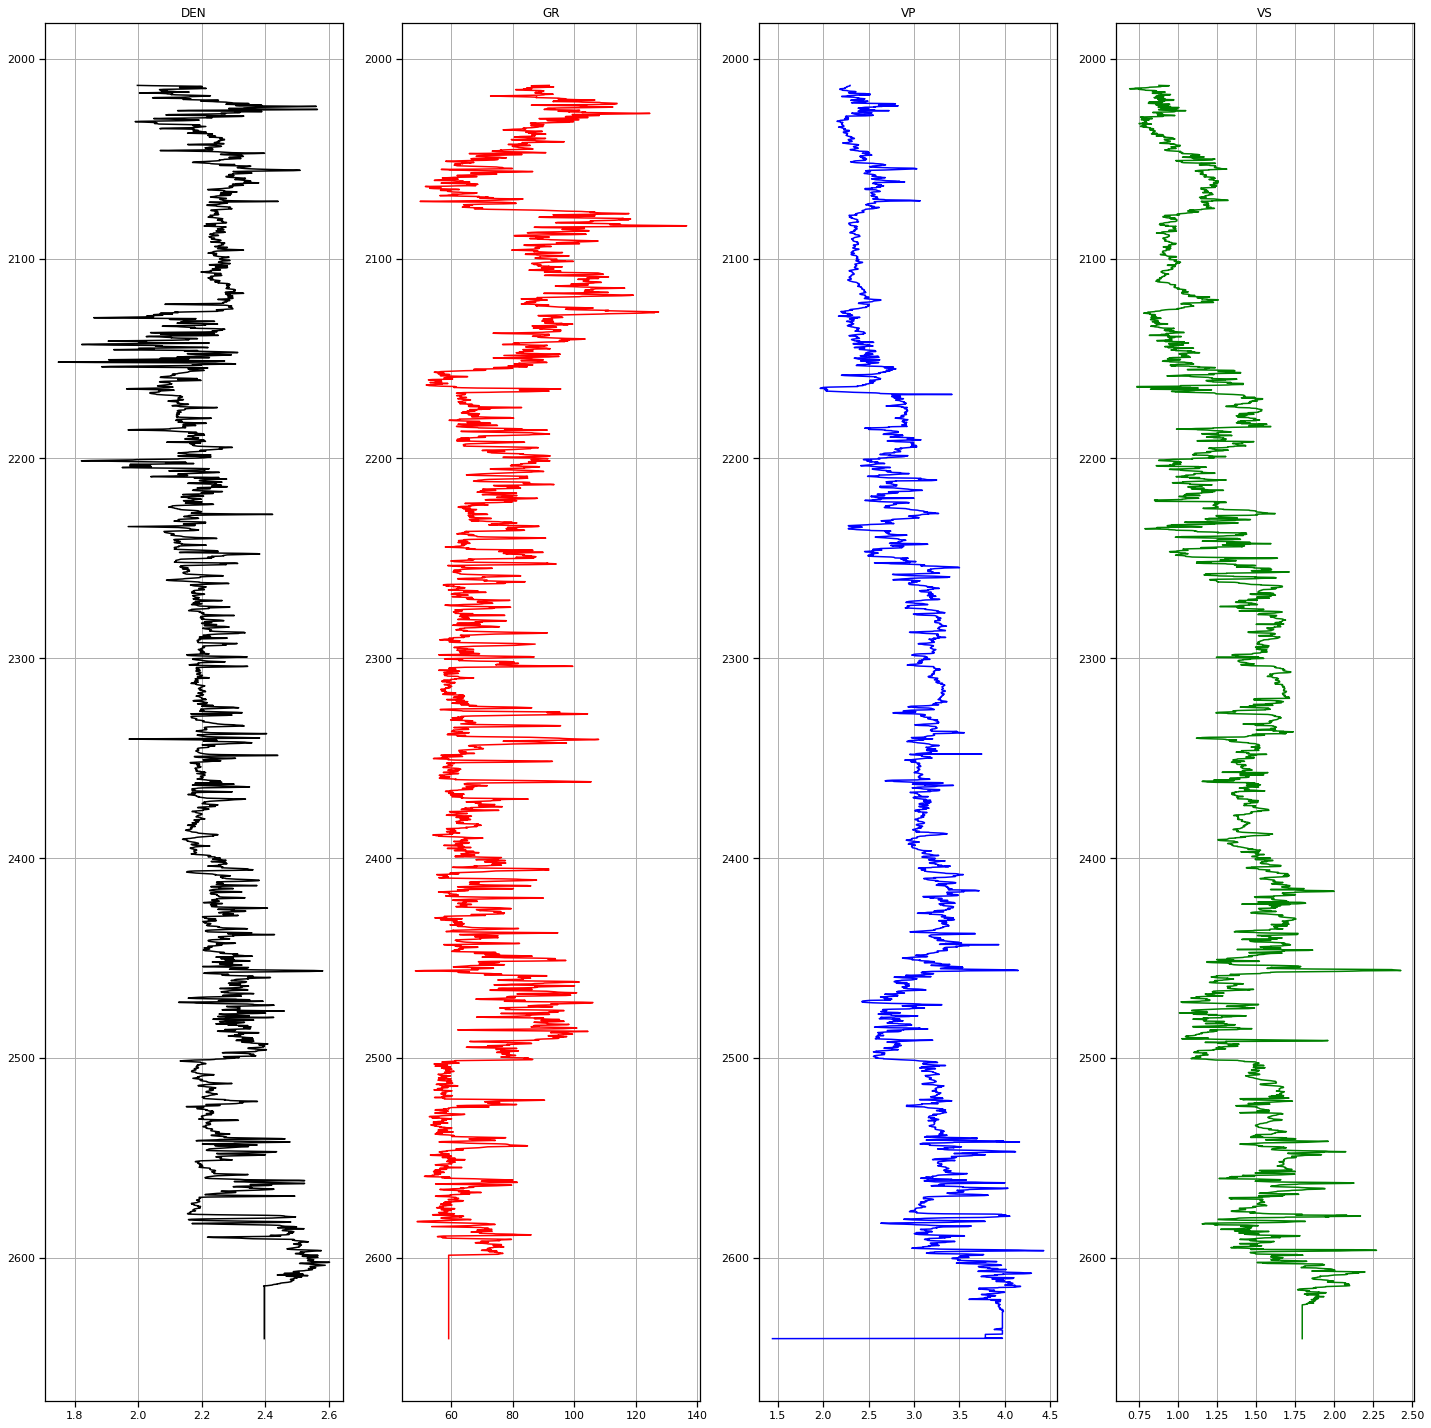

In [20]:
# Display train well data
well = well2 # train well: well2

# define what logs are we going to us
logs = ['DEN', 'GR', 'VP', 'VS']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,20))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green']

for i in range(len(logs)):
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
    ax[i].set_title(logs[i])
    ax[i].grid(True)
    ax[i].invert_yaxis()

#ax[2].set_xlim(0, 300)
plt.tight_layout()
plt.show()

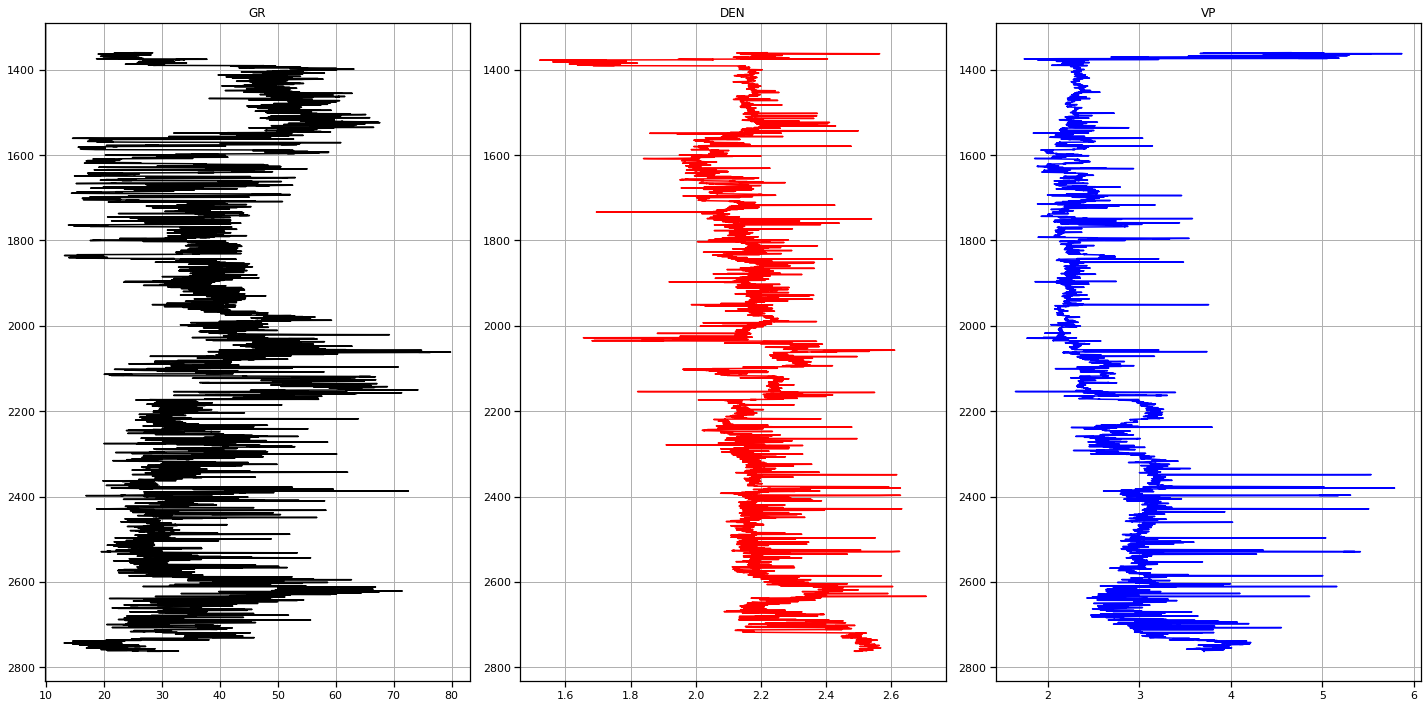

In [21]:
# Display test well data
well = well1 # test wells: well1, well3, well4, well5

# define what logs are we going to us
logs = ['GR', 'DEN', 'VP']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green']

for i in range(len(logs)):
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
    ax[i].set_title(logs[i])
    ax[i].grid(True)
    ax[i].invert_yaxis()

#ax[2].set_xlim(0, 300)
plt.tight_layout()
plt.show()

Cross-plot of acoustic impedance vs Vp/Vs ratio colour-coded to volume shale

Cross-plot of acoustic impedance vs Vp/Vs ratio colour-coded to porosity

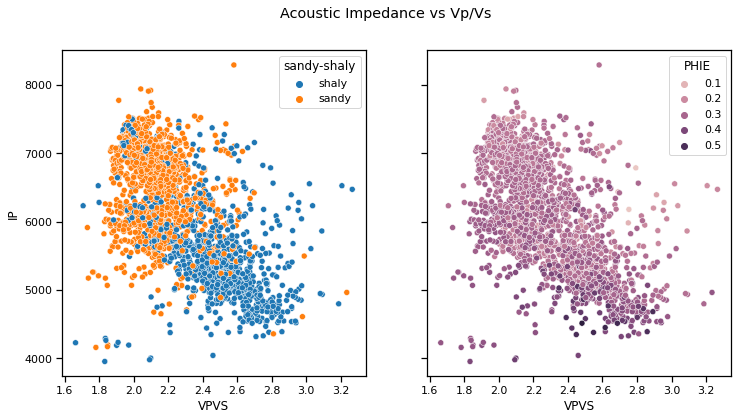

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))
fig.suptitle('Acoustic Impedance vs Vp/Vs')
sns.scatterplot(ax=ax1, x=well2[well2['DEPTH']<2400]['VPVS'], y=well2['IP'], hue=well2['sandy-shaly'])
sns.scatterplot(ax=ax2, x=well2[well2['DEPTH']<2400]['VPVS'], y=well2['IP'], hue=well2['PHIE'])

for ax in fig.get_axes():
    ax.label_outer()

Histogram of acoustic impedance and Vp/Vs ratio for sandy (Vsh < 0.35) facies.

Histogram of acoustic impedance and Vp/Vs ratio for shaly (Vsh > 0.35) facies.

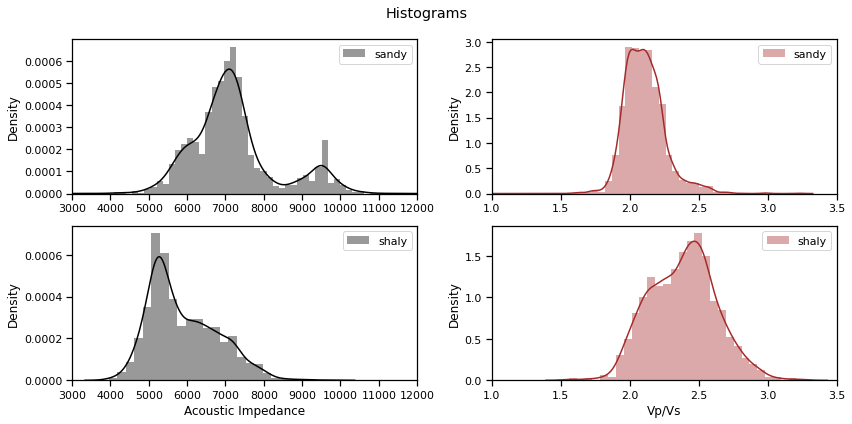

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('Histograms')
sns.distplot(ax=ax1, x=well2[well2['sandy-shaly']=='sandy']['IP'], color="black", label="sandy")
sns.distplot(ax=ax2, x=well2[well2['sandy-shaly']=='sandy']['VPVS'], color="brown", label="sandy")
sns.distplot(ax=ax3, x=well2[well2['sandy-shaly']=='shaly']['IP'], color="black", label="shaly")
sns.distplot(ax=ax4, x=well2[well2['sandy-shaly']=='shaly']['VPVS'], color="brown", label="shaly")

ax1.set_xlim(3000,12000)#,  ax.set_ylim(2e3,4e3)
ax3.set_xlim(3000,12000)#,  ax.set_ylim(2e3,4e3)
ax3.set_xlabel('Acoustic Impedance')

ax2.set_xlim(1,3.5)#,  ax.set_ylim(2e3,4e3)
ax4.set_xlim(1,3.5)#,  ax.set_ylim(2e3,4e3)
ax4.set_xlabel('Vp/Vs')

plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()

#### Facies

### 5.2.2 Pore-fluid effects

### 5.2.3 Acoustic and elastic impedance

* Shear wave not obtained in well1.
* Estimate Vs using Vp-Vs relations calibrated from wells where shear logs are available (well2, well5).
* Test various models for predicting Vs from P-wave velocity, porosity, and shale volume.
* What is the prediction error? -> Include error percent in Monte-Carlo simulations for estimating pdfs

#### Sandstones and shales
Ref Castagna et al (1985, 1993), Thomsen (1986)

In [25]:
# Vp-Vs Models
vpx = np.linspace(2.2, 3.4, 100)
vs_cast2 = -0.05508*vpx**2 + 1.0168*vpx - 1.0305
vs_cast = 0.8042*vpx - 0.8559
vs_mudrock = 0.8621*vpx - 1.1724
vs_han = 0.7936*vpx - 0.7868
vs_79 = 0.79*vpx - 0.79

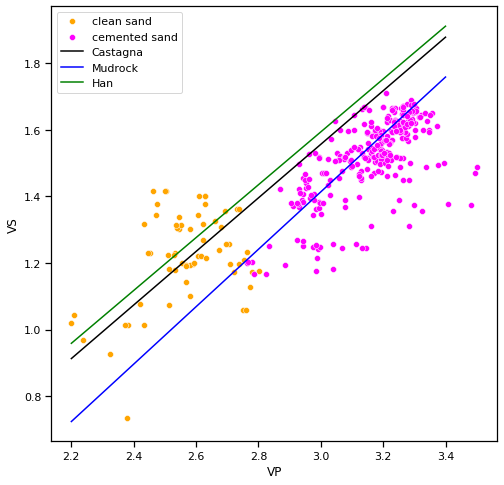

In [26]:
plt.figure(figsize=(8,8))
ll = well2[(well2.DEPTH > 2000) & (well2.DEPTH < 2400)]
#sns.scatterplot(x=ll[ll.FACIES==facies[0]]['VP'], y=ll[ll.FACIES==facies[0]]['VS'], color="black", label='shale')
#sns.scatterplot(x=ll[ll.FACIES==facies[1]]['VP'], y=ll[ll.FACIES==facies[1]]['VS'], color="brown", label='silty shale')
sns.scatterplot(x=ll[ll.FACIES==facies[2]]['VP'], y=ll[ll.FACIES==facies[2]]['VS'], color="orange", label='clean sand')
#sns.scatterplot(x=ll[ll.FACIES==facies[3]]['VP'], y=ll[ll.FACIES==facies[3]]['VS'], color="purple", label='silt sand 1')
#sns.scatterplot(x=ll[ll.FACIES==facies[4]]['VP'], y=ll[ll.FACIES==facies[4]]['VS'], color="red", label='silt sand 2')
sns.scatterplot(x=ll[ll.FACIES==facies[5]]['VP'], y=ll[ll.FACIES==facies[5]]['VS'], color="magenta", label='cemented sand')
#plt.plot(vpx, vs_cast2, 'r', label="Castagna 2")
plt.plot(vpx, vs_cast, 'k', label="Castagna")
plt.plot(vpx, vs_mudrock, 'b', label="Mudrock")
plt.plot(vpx, vs_han, 'g', label="Han")
#plt.plot(vpx, vs_79, 'magenta', label="79")
plt.legend();

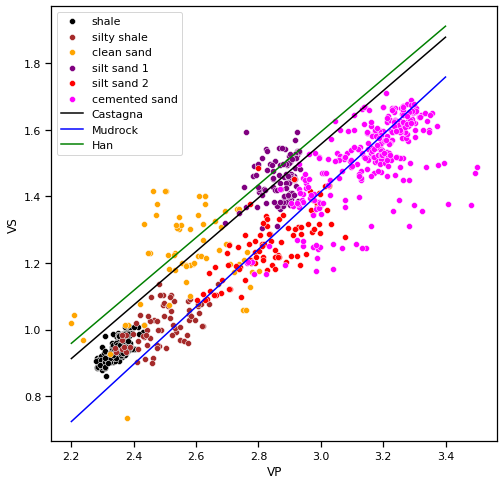

In [27]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=well2[well2.FACIES==facies[0]]['VP'], y=well2[well2.FACIES==facies[0]]['VS'], color="black", label='shale')
sns.scatterplot(x=well2[well2.FACIES==facies[1]]['VP'], y=well2[well2.FACIES==facies[1]]['VS'], color="brown", label='silty shale')
sns.scatterplot(x=well2[well2.FACIES==facies[2]]['VP'], y=well2[well2.FACIES==facies[2]]['VS'], color="orange", label='clean sand')
sns.scatterplot(x=well2[well2.FACIES==facies[3]]['VP'], y=well2[well2.FACIES==facies[3]]['VS'], color="purple", label='silt sand 1')
sns.scatterplot(x=well2[well2.FACIES==facies[4]]['VP'], y=well2[well2.FACIES==facies[4]]['VS'], color="red", label='silt sand 2')
sns.scatterplot(x=well2[well2.FACIES==facies[5]]['VP'], y=well2[well2.FACIES==facies[5]]['VS'], color="magenta", label='cemented sand')
#plt.plot(vpx, vs_cast2, 'r', label="Castagna 2")
plt.plot(vpx, vs_cast, 'k', label="Castagna")
plt.plot(vpx, vs_mudrock, 'b', label="Mudrock")
plt.plot(vpx, vs_han, 'g', label="Han")
#plt.plot(vpx, vs_79, 'magenta', label="79")
plt.legend();

Use Castagna et al (1993) $V_S = 0.8042V_P - 0.8559$

In [28]:
well1['VS'] = 0.8042*well1['VP'] - 0.8559
well1['VPVS'] = well1.VP / well1.VS
well1['IP'] = well1.VP * well1.DEN
well1['IS'] = well1.VS * well1.DEN

$ I_e(\theta) = \Big(  V_P^{1+tan^2\theta} \Big) \Big( \rho^{1-4(V_S/V_P)^2\sin^2\theta} \Big) \Big( V_S^{-8(V_S/V_P)^2\sin^2\theta}  \Big) $

In [29]:
theta = 30
K = 1/well1.VPVS
a = 1 + (np.tan(np.radians(theta)))**2
b = -8 * K * (np.sin(np.radians(theta))**2)
c = 1 - 4*K*(np.sin(np.radians(theta)))**2

well1['EI30'] = (well1.VP)**a * (well1.VS)**b * (well1.DEN)**c
well1.head()

,DEPTH,VP,DEN,GR,VS,VPVS,IP,IS,EI30
0,1360.125,4.65708,2.2185,25.2231,2.889324,1.611824,10.331732,6.409965,2.821026
1,1360.250,4.40293,2.2091,27.7205,2.684936,1.639864,9.726513,5.931293,2.947808
2,1360.375,4.40173,2.1963,28.3927,2.683971,1.640006,9.667520,5.894806,2.941783
3,1360.500,4.42270,2.1834,26.6719,2.700835,1.637530,9.656523,5.897004,2.923740
4,1360.625,4.44917,2.1610,24.5829,2.722123,1.634449,9.614656,5.882507,2.898007


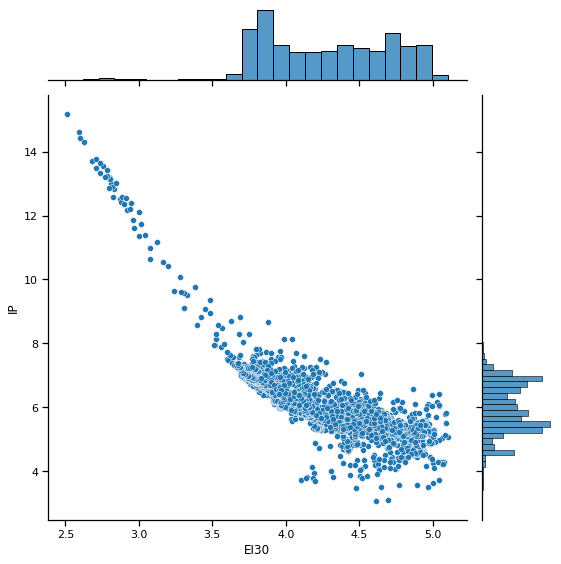

In [30]:
fig.suptitle('Acoustic Impedance vs Elastic Impedance')
sns.jointplot(x="EI30", 
              y="IP", 
              data=well1[(well1.DEPTH > 2000) & (well1.DEPTH < 2400)],
              height=8,
              )

In [31]:

theta = 30
K = 1/well2.VPVS
a = 1 + (np.tan(np.radians(theta)))**2
b = -8 * K * (np.sin(np.radians(theta))**2)
c = 1 - 4*K*(np.sin(np.radians(theta)))**2
# added 2x factor to rescale
well2['EI30'] = 2*((well2.VP)**a * (well2.VS)**b * (well2.DEN)**c)


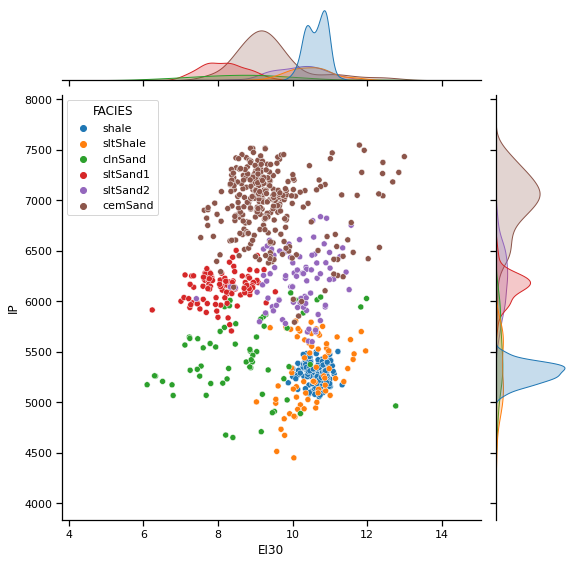

In [32]:

fig.suptitle('Acoustic Impedance vs Elastic Impedance')
sns.jointplot(ax=ax, x="EI30", 
              y="IP", 
              data=well2[well2.FACIES!='0'],
              hue='FACIES',
              height=8,
              )
#plt.figure(figsize=(8,8))
#sns.scatterplot(data=well2[well2.FACIES!='0'], x="EI30", y="IP", hue='FACIES');

In [33]:
rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine
rho_o=0.78;   k_o=0.94              # fluid properties, oil
rho_g=0.25;   k_g=0.06              # fluid properties, gas

In [34]:
RHO_qz = 2.6;   K_qz = 37;  MU_qz = 44
RHO_sh = 2.8;   K_sh = 15;  MU_sh = 5
RHO_b = 1.1 ;   K_b = 2.8 
RHO_o = 0.8;    K_o = 0.9
RHO_g = 0.2;    K_g = 0.06              

Cn = 8
phic = 0.4
f = 1

phi=np.linspace(0.01, 0.4)

In [35]:
sty0 = {'lw':1, 'color':'k', 'ls':'-'}
sty1 = {'marker':'o', 'color':'g', 'ls':'none', 'ms':6, 'mec':'none', 'alpha':0.5}
sty2 = {'marker':'o', 'color':'r', 'ls':'none', 'ms':6, 'mec':'none', 'alpha':0.5}